In [ ]:
%%capture
!pip install datasets transformers peft torchmetrics

In [ ]:
import os
import subprocess

import numpy as np

from random import sample
from IPython.display import clear_output
from tqdm import tqdm

import torch
from torch import nn
from torch.optim import AdamW
from torch.utils.data import DataLoader
from torchmetrics.functional import accuracy

from peft import get_peft_model, LoraConfig, TaskType
from transformers import AutoTokenizer, AutoModelForSequenceClassification

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

In [ ]:
os.environ['TOKENIZERS_PARALLELISM'] = 'false'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Датасет

В качестве датасета возьмем один из датасетов бенчмарка GLUE - [SST2](https://huggingface.co/datasets/sst2) (Stanford Sentiment Treebank).

Датасет содержит 67 тысяч предложений с отзывами на фильмы, которые требуется классифицировать на положительные и отрицательные.

In [ ]:
from datasets import load_dataset

train_dataset = load_dataset("glue", "sst2", split='train[:20000]')
valid_dataset = load_dataset("glue", "sst2", split="validation")

README.md:   0%|          | 0.00/35.3k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/3.11M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/72.8k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/148k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/67349 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/872 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1821 [00:00<?, ? examples/s]

In [ ]:
train_dataset[0]

{'sentence': 'hide new secretions from the parental units ',
 'label': 0,
 'idx': 0}

In [ ]:
train_dataset[2]

{'sentence': 'that loves its characters and communicates something rather beautiful about human nature ',
 'label': 1,
 'idx': 2}

In [ ]:
len(train_dataset), len(valid_dataset)

(20000, 872)

### Инициализация токенизатора и модели

In [ ]:
model_checkpoint = "gpt2"

In [ ]:
# Initializing the tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
tokenizer.add_special_tokens({'pad_token': '[PAD]'})

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

1

In [ ]:
class Model(nn.Module):
    def __init__(self, tokenizer, num_classes=2):
        super().__init__()
        self.model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=num_classes)
        self.model.resize_token_embeddings(len(tokenizer))
        self.config = self.model.config

    def forward(self, input_ids=None, attention_mask=None, inputs_embeds=None, *args, **kwargs):
        out = self.model.transformer(
            input_ids=input_ids, inputs_embeds=inputs_embeds, attention_mask=attention_mask
        ).last_hidden_state
        lens = attention_mask.sum(-1).cpu() - 1
        out = out[torch.arange(len(lens)), lens.to(torch.long)]
        return self.model.score(out)

    @property
    def device(self):
        return next(self.model.parameters()).device


num_classes = 2
model = Model(tokenizer, num_classes)

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


In [ ]:
model

Model(
  (model): GPT2ForSequenceClassification(
    (transformer): GPT2Model(
      (wte): Embedding(50258, 768)
      (wpe): Embedding(1024, 768)
      (drop): Dropout(p=0.1, inplace=False)
      (h): ModuleList(
        (0-11): 12 x GPT2Block(
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (attn): GPT2SdpaAttention(
            (c_attn): Conv1D(nf=2304, nx=768)
            (c_proj): Conv1D(nf=768, nx=768)
            (attn_dropout): Dropout(p=0.1, inplace=False)
            (resid_dropout): Dropout(p=0.1, inplace=False)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): GPT2MLP(
            (c_fc): Conv1D(nf=3072, nx=768)
            (c_proj): Conv1D(nf=768, nx=3072)
            (act): NewGELUActivation()
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
      )
      (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    )
    (score): Linear(in_features=768, out

In [ ]:
sum(p.numel() for p in model.parameters())

124442112

### Подготовка данных

In [ ]:
batch_size = 128

train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size, num_workers=8)
valid_loader = DataLoader(valid_dataset, shuffle=False, batch_size=batch_size, num_workers=8)

/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
print("       0       1")
classes = [t["label"] for t in train_dataset]
print(f"Train: {1 - np.mean(classes):0.3f} {np.mean(classes):0.3f}")

classes = [t["label"] for t in valid_dataset]
print(f"Valid: {1 - np.mean(classes):0.3f} {np.mean(classes):0.3f}")

       0       1
Train: 0.446 0.554
Valid: 0.491 0.509


### Train loop

In [ ]:
model.to(device)

In [ ]:
def training_loop_fn(model, opt, total_num_iters, eval_freq, train_loader, valid_loader):
    train_loss_history, eval_loss_history = [], []
    train_acc_history, eval_acc_history = [], []
    global_step = 0

    criterion = torch.nn.CrossEntropyLoss()
    model.train()
    while True:
        for batch in tqdm(train_loader):
            tokenized = tokenizer(batch["sentence"], padding=True, return_tensors='pt')
            for k, v in tokenized.items():
                tokenized[k] = v.to(device)

            with torch.autocast(device_type='cuda', dtype=torch.float16):
                logits = model(tokenized['input_ids'], tokenized['attention_mask'], return_dict=False)
            targets = batch["label"].to(device)
            loss = criterion(logits, targets)

            opt.zero_grad()
            loss.backward()
            opt.step()

            preds = torch.nn.functional.softmax(logits, dim=-1)[:, 1]
            acc = accuracy(preds, targets, "binary")

            train_loss_history.append((global_step, loss.item()))
            train_acc_history.append((global_step, acc.item()))

            if global_step % eval_freq == 0:
                val_loss, val_acc = evaluate(model, valid_loader)
                eval_loss_history.append((global_step, val_loss))
                eval_acc_history.append((global_step, val_acc))

                model.train()

            if global_step % 250 == 0:
                clear_output(True)

                plt.figure(figsize=(15, 5))

                plt.subplot(121)
                plt.plot(*zip(*train_loss_history), alpha=0.5, label='train_loss')
                if len(eval_loss_history):
                    plt.plot(*zip(*eval_loss_history), color='red', label='eval_loss')
                plt.legend()

                plt.subplot(122)
                plt.plot(*zip(*train_acc_history), alpha=0.5, label='train_acc')
                if len(eval_acc_history):
                    plt.plot(*zip(*eval_acc_history), color='red', label='eval_acc')
                plt.legend()
                plt.show()

            global_step += 1
            if global_step > total_num_iters:
                break
        else:
            continue
        break


@torch.no_grad()
def evaluate(model, dataloader):
    model.eval()
    criterion = torch.nn.CrossEntropyLoss()
    loss_epoch = 0.
     = 0.
    preds_list = []
    targets_list = []

    for eval_batch in dataloader:
        tokenized = tokenizer(eval_batch["sentence"], padding=True, return_tensors='pt')
        for k, v in tokenized.items():
            tokenized[k] = v.to(device)

        with torch.autocast(device_type='cuda', dtype=torch.float16):
            logits = model(tokenized['input_ids'], tokenized['attention_mask'], return_dict=False)

        loss = criterion(logits, eval_batch["label"].to(device))
        num = logits.shape[0]

        loss_epoch += loss.item() * num
        num_epoch += num
        preds = torch.nn.functional.softmax(logits, dim=-1)[:, 1]

        targets_list += eval_batch["label"].tolist()
        preds_list += preds.tolist()

    acc = accuracy(torch.tensor(preds_list).to(device), torch.tensor(targets_list).to(device), "binary")

    return loss_epoch / num_epoch, acc.item()

## Fine-tuning


In [ ]:
model = Model(tokenizer, num_classes).to(device)
optimizer = AdamW(model.parameters(), lr=2e-6)

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


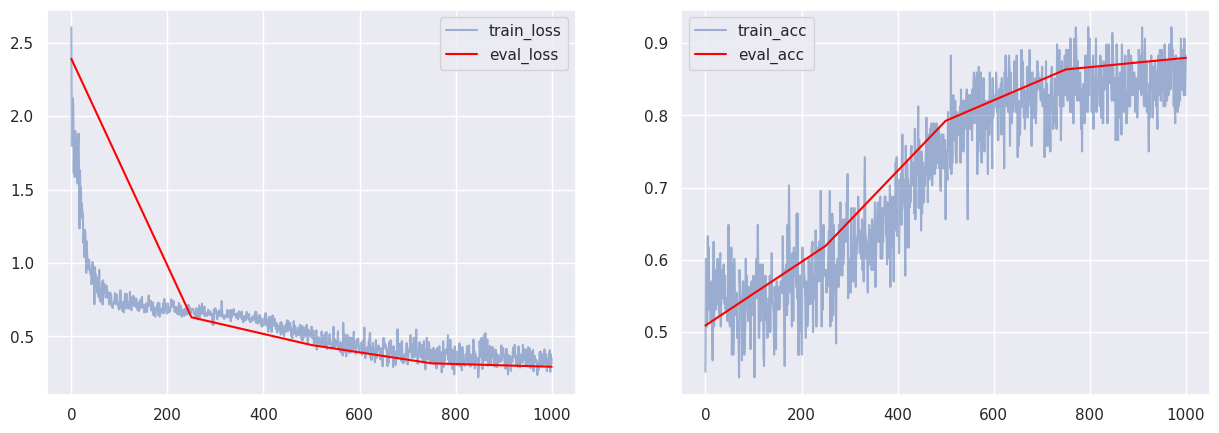

 37%|███▋      | 58/157 [00:28<00:48,  2.05it/s]

CPU times: user 7min 20s, sys: 5.77 s, total: 7min 25s
Wall time: 7min 26s


In [ ]:
%%time
training_loop_fn(model, optimizer, 1000, 250, train_loader, valid_loader)

In [ ]:
val_loss, val_acc = evaluate(model, valid_loader)
print(f'val loss: {val_loss}')
print(f'val accuracy: {val_acc}')

val loss: 0.29354886396215596
val accuracy: 0.8795871734619141


## Linear Probing

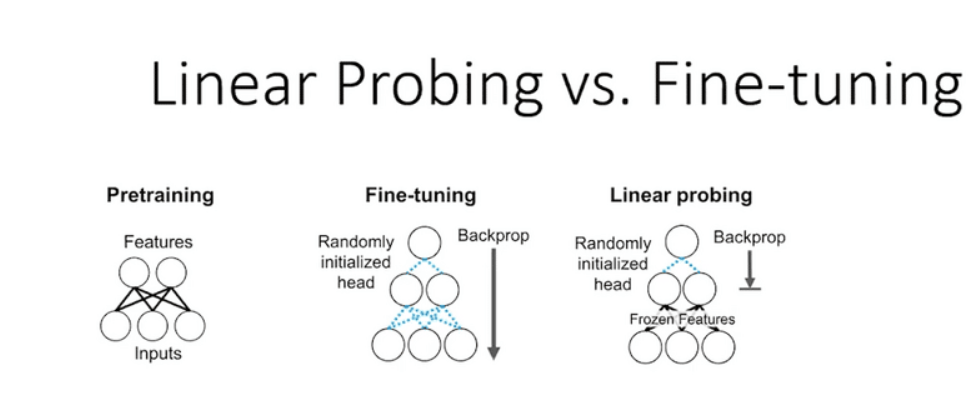

In [ ]:
del model

In [ ]:
torch.cuda.empty_cache()

In [ ]:
model = Model(tokenizer, num_classes).to(device)
optimizer = AdamW(model.model.score.parameters(), lr=1e-4)

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


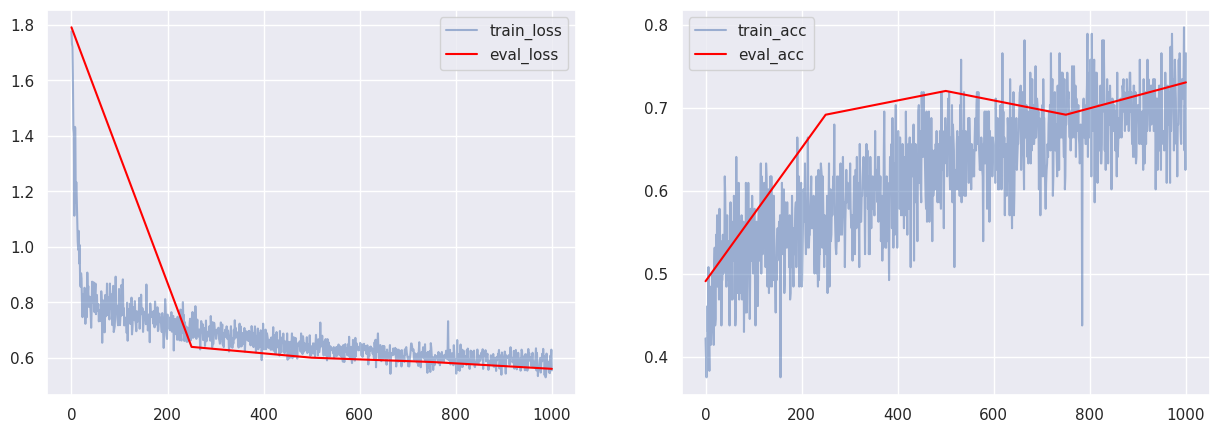

 37%|███▋      | 58/157 [00:26<00:45,  2.19it/s]

CPU times: user 6min 52s, sys: 6.07 s, total: 6min 58s
Wall time: 6min 58s


In [ ]:
%%time
training_loop_fn(model, optimizer, 1000, 250, train_loader, valid_loader)

In [ ]:
val_loss, val_acc = evaluate(model, valid_loader)
print(f'val loss: {val_loss}')
print(f'val accuracy: {val_acc}')

val loss: 0.5603452909977065
val accuracy: 0.73050457239151


In [ ]:
torch.save(model.model.score.state_dict(), "head.pt")

## LoRA

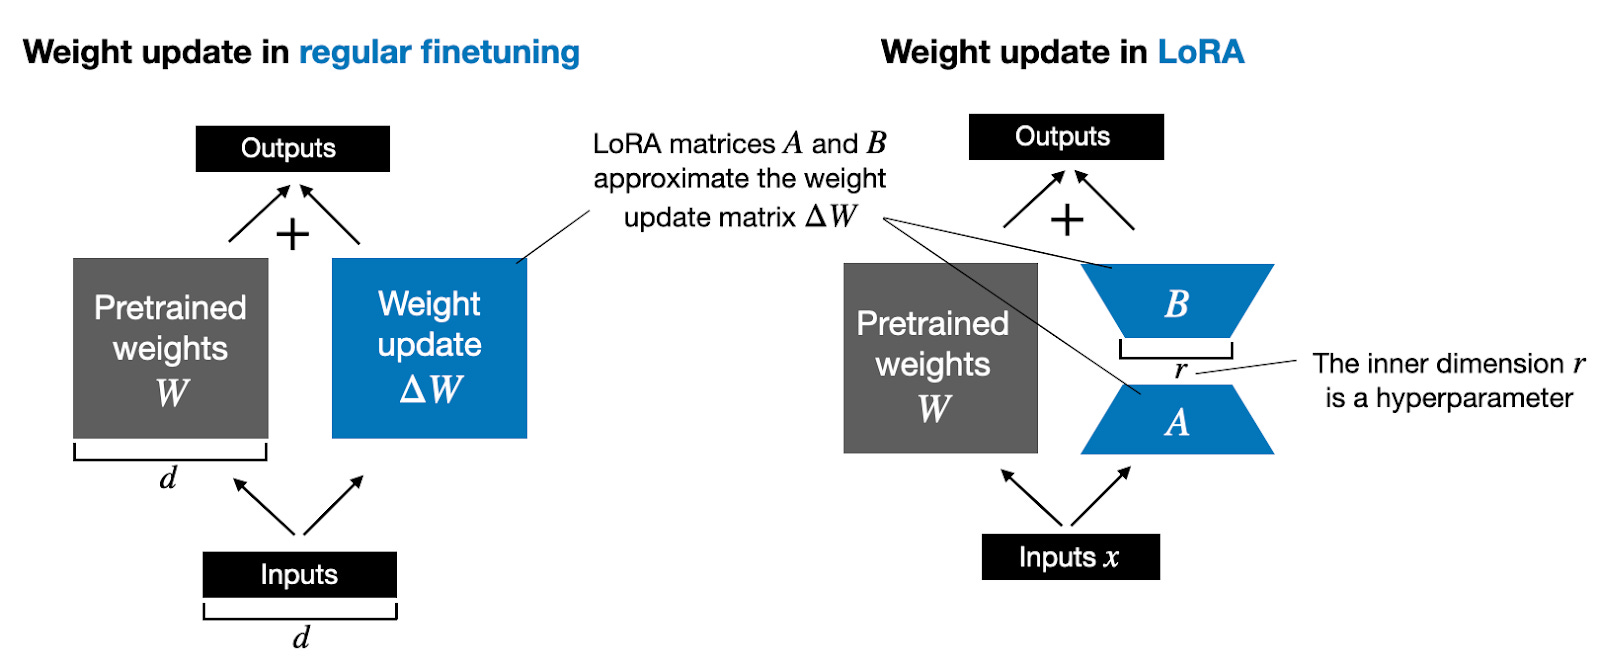

Самый важный параметр этой модели – ранг матриц $A$ и $B$ ($r$). Его увеличение дает больше степеней свободы в настройке добавки $AB$, повышая вместе с этим количество обучаемых параметров.

In [ ]:
model

Model(
  (model): GPT2ForSequenceClassification(
    (transformer): GPT2Model(
      (wte): Embedding(50258, 768)
      (wpe): Embedding(1024, 768)
      (drop): Dropout(p=0.1, inplace=False)
      (h): ModuleList(
        (0-11): 12 x GPT2Block(
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (attn): GPT2SdpaAttention(
            (c_attn): Conv1D(nf=2304, nx=768)
            (c_proj): Conv1D(nf=768, nx=768)
            (attn_dropout): Dropout(p=0.1, inplace=False)
            (resid_dropout): Dropout(p=0.1, inplace=False)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): GPT2MLP(
            (c_fc): Conv1D(nf=3072, nx=768)
            (c_proj): Conv1D(nf=768, nx=3072)
            (act): NewGELUActivation()
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
      )
      (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    )
    (score): Linear(in_features=768, out

In [ ]:
peft_config = LoraConfig(
    task_type=TaskType.SEQ_CLS, inference_mode=False, r=8, lora_dropout=0.1, target_modules=['c_attn']
)

model = Model(tokenizer, num_classes).to(device)
lora_model = get_peft_model(model, peft_config).to(device)
lora_model.print_trainable_parameters()

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 296,448 || all params: 124,738,560 || trainable%: 0.2377


/opt/conda/lib/python3.10/site-packages/peft/tuners/lora/layer.py:1264: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


In [ ]:
sum(p.numel() for p in lora_model.parameters() if p.requires_grad)

296448

In [ ]:
optimizer = AdamW(lora_model.parameters(), lr=1e-4)

In [ ]:
torch.cuda.empty_cache()

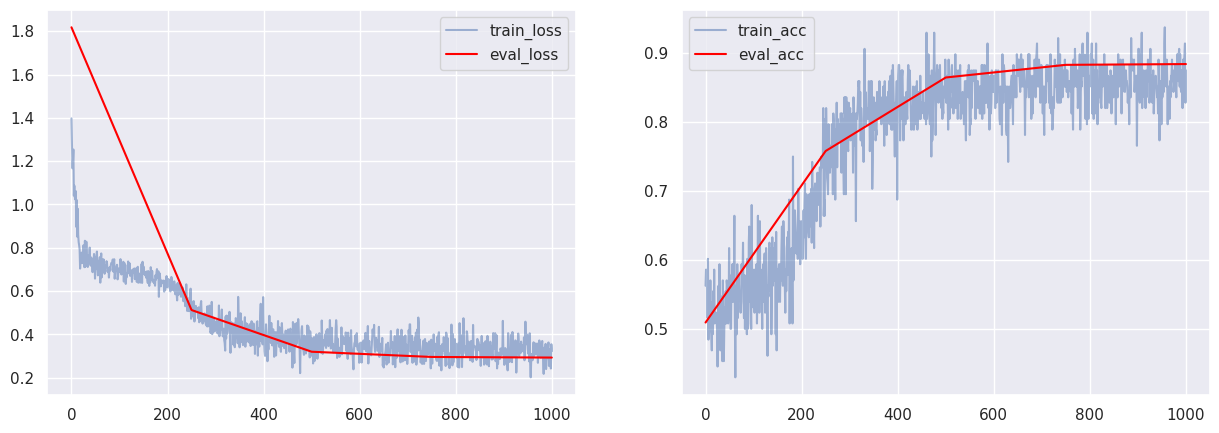

 37%|███▋      | 58/157 [00:24<00:42,  2.35it/s]

CPU times: user 6min 18s, sys: 5.8 s, total: 6min 24s
Wall time: 6min 24s


In [ ]:
%%time
training_loop_fn(lora_model, optimizer, 1000, 250, train_loader, valid_loader)

In [ ]:
val_loss, val_acc = evaluate(lora_model, valid_loader)
print(f'val loss: {val_loss}')
print(f'val accuracy: {val_acc}')

val loss: 0.2932868047591743
val accuracy: 0.8841742873191833


In [ ]:
torch.save(lora_model.base_model.model.model.score.state_dict(), 'lora_head.pt')

## LP-FT


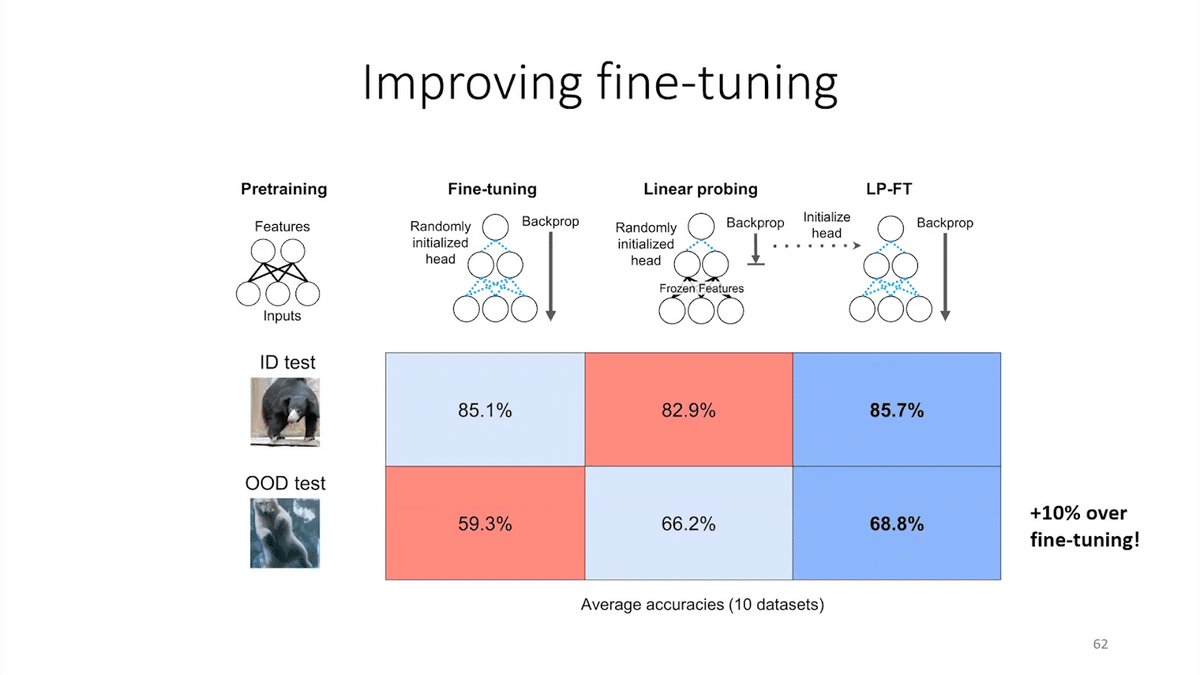

In [ ]:
chkpt = torch.load('head.pt')
chkpt.keys()

/tmp/ipykernel_23/3647206314.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  chkpt = torch.load('head.pt')


odict_keys(['weight'])

In [ ]:
chkpt

OrderedDict([('weight',
              tensor([[-0.0034,  0.0416,  0.0014,  ..., -0.0177, -0.0448,  0.0293],
                      [-0.0333,  0.0038, -0.0227,  ..., -0.0170, -0.0062, -0.0233]],
                     device='cuda:0'))])

In [ ]:
model = Model(tokenizer, num_classes).to(device)
model.model.score.load_state_dict(chkpt)
optimizer = AdamW(model.parameters(), lr=2e-6)

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


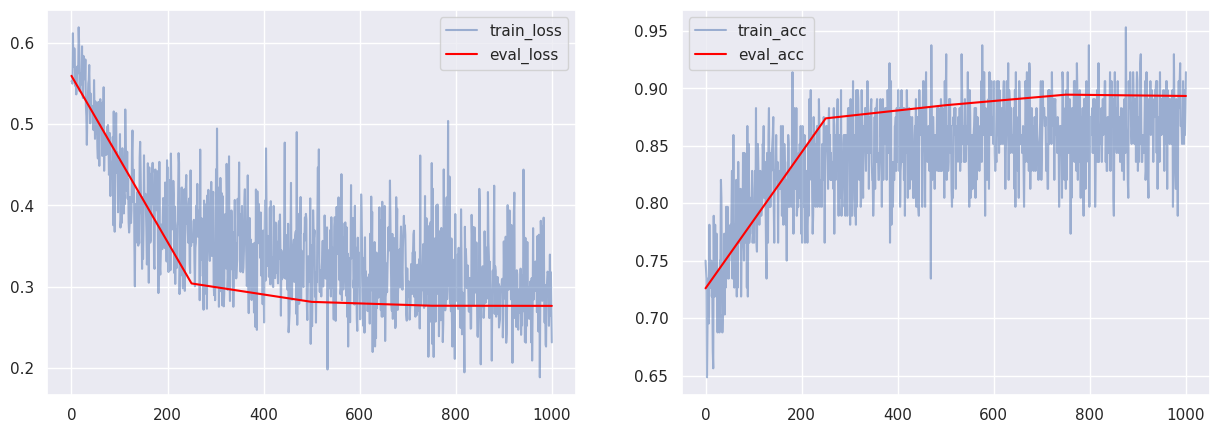

 37%|███▋      | 58/157 [00:27<00:47,  2.08it/s]

CPU times: user 7min 24s, sys: 5.38 s, total: 7min 30s
Wall time: 7min 29s


In [ ]:
%%time
training_loop_fn(model, optimizer, 1000, 250, train_loader, valid_loader)

In [ ]:
val_loss, val_acc = evaluate(model, valid_loader)
print(f'val loss: {val_loss}')
print(f'val accuracy: {val_acc}')

val loss: 0.2764746989678899
val accuracy: 0.8933486342430115


### Testing the model

In [ ]:
@torch.no_grad()
def predict(text, target=0):
    tokenized = tokenizer(text, return_tensors='pt')
    for k, v in tokenized.items():
        tokenized[k] = v.to(device)

    logits = model(tokenized['input_ids'], tokenized['attention_mask'], return_dict=False)
    probs = torch.nn.functional.softmax(logits, dim=-1)

    predicted_class_id = int(torch.argmax(logits, dim=-1))
    print(f"text: {text}")
    print(f"target: {target}, pred: {predicted_class_id}")
    print("probs:", probs.cpu().numpy())

In [ ]:
predict("this movie is amaizing", 1)

text: this movie is amaizing
target: 1, pred: 0
probs: [[0.6556897 0.3443103]]


In [ ]:
for i in range(10):
    text = valid_dataset[i]["sentence"]
    label = valid_dataset[i]["label"]
    predict(text, label)
    print()

text: it 's a charming and often affecting journey . 
target: 1, pred: 1
probs: [[0.00120772 0.9987923 ]]

text: unflinchingly bleak and desperate 
target: 0, pred: 0
probs: [[0.86682385 0.1331761 ]]

text: allows us to hope that nolan is poised to embark a major career as a commercial yet inventive filmmaker . 
target: 1, pred: 1
probs: [[0.02233851 0.97766143]]

text: the acting , costumes , music , cinematography and sound are all astounding given the production 's austere locales . 
target: 1, pred: 1
probs: [[0.00917815 0.99082184]]

text: it 's slow -- very , very slow . 
target: 0, pred: 0
probs: [[0.97168535 0.02831473]]

text: although laced with humor and a few fanciful touches , the film is a refreshingly serious look at young women . 
target: 1, pred: 1
probs: [[0.00948013 0.9905199 ]]

text: a sometimes tedious film . 
target: 0, pred: 0
probs: [[0.9612496  0.03875044]]

text: or doing last year 's taxes with your ex-wife . 
target: 0, pred: 0
probs: [[0.8629173  0.1370827